# **Salinas**

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Dataset
file_path = "/content/drive/MyDrive/Salinas_Reduced.csv"
df = pd.read_csv(file_path)

# Extract Features and Labels
X = df.iloc[:, :-1].values  # First 204 columns as features
y = df.iloc[:, -1].values   # Last column as labels

# Standardize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to Tensors
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.long, device=device)

# Augmentation Functions
def add_gaussian_noise(X, mean=0, std=0.01):
    noise = np.random.normal(mean, std, X.shape)
    return np.clip(X + noise, -1, 1)

def mixup(X1, X2, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    return lam * X1 + (1 - lam) * X2

def augment_data(X, prob=0.5):
    if np.random.rand() < prob:
        X = add_gaussian_noise(X)
    return X

# Few-Shot Data Creation
def create_few_shot_batches(X, y, n_way=5, k_shot=5, query_per_class=10, episodes=500):
    unique_classes = np.unique(y)
    dataset = []

    for _ in range(episodes):
        selected_classes = np.random.choice(unique_classes, n_way, replace=False)
        support_set, query_set = [], []
        support_labels, query_labels = [], []

        for i, cls in enumerate(selected_classes):
            indices = np.where(y == cls)[0]
            selected_indices = np.random.choice(indices, k_shot + query_per_class, replace=False)

            support_set.append(augment_data(X[selected_indices[:k_shot]]))
            query_set.append(X[selected_indices[k_shot:]])
            support_labels.extend([i] * k_shot)
            query_labels.extend([i] * query_per_class)

        dataset.append((np.vstack(support_set), np.array(support_labels),
                        np.vstack(query_set), np.array(query_labels)))

    return dataset

n_way, k_shot, query_per_class = 5, 5, 10
episodes = 500
few_shot_data = create_few_shot_batches(X, y, n_way, k_shot, query_per_class, episodes)

# Improved Feature Extractor
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc = nn.Linear(256 * 204, 256)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Prototypical Network with Euclidean Distance
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = SpectralFeatureExtractor()

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)

        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# Initialize Model
model = PrototypicalNetwork().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
criterion = nn.CrossEntropyLoss()

# Training
def train_few_shot_model(model, data, optimizer, criterion, scheduler, epochs=300):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for support_x, support_y, query_x, query_y in data:
            support_x = torch.tensor(support_x, dtype=torch.float32, device=device)
            query_x = torch.tensor(query_x, dtype=torch.float32, device=device)
            query_y = torch.tensor(query_y, dtype=torch.long, device=device)

            optimizer.zero_grad()
            outputs = model(support_x, query_x)
            loss = criterion(outputs, query_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            total_correct += (outputs.argmax(dim=1) == query_y).sum().item()
            total_samples += query_y.size(0)

        epoch_acc = total_correct / total_samples * 100
        print(f"Epoch {epoch+1}/{epochs}, Accuracy: {epoch_acc:.2f}%")

train_few_shot_model(model, few_shot_data, optimizer, criterion, scheduler)

# Evaluation
def evaluate_few_shot_model(model, data):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for support_x, support_y, query_x, query_y in data:
            support_x = torch.tensor(support_x, dtype=torch.float32, device=device)
            query_x = torch.tensor(query_x, dtype=torch.float32, device=device)
            query_y = torch.tensor(query_y, dtype=torch.long, device=device)

            outputs = model(support_x, query_x)
            total_correct += (outputs.argmax(dim=1) == query_y).sum().item()
            total_samples += query_y.size(0)

    print(f"Final Accuracy: {total_correct / total_samples * 100:.2f}%")

evaluate_few_shot_model(model, few_shot_data)

Using device: cuda
Epoch 1/300, Accuracy: 90.36%
Epoch 2/300, Accuracy: 93.48%
Epoch 3/300, Accuracy: 94.87%
Epoch 4/300, Accuracy: 95.15%
Epoch 5/300, Accuracy: 96.16%
Epoch 6/300, Accuracy: 96.87%
Epoch 7/300, Accuracy: 97.26%
Epoch 8/300, Accuracy: 97.33%
Epoch 9/300, Accuracy: 97.47%
Epoch 10/300, Accuracy: 97.79%
Epoch 11/300, Accuracy: 98.08%
Epoch 12/300, Accuracy: 98.15%
Epoch 13/300, Accuracy: 98.34%
Epoch 14/300, Accuracy: 98.26%
Epoch 15/300, Accuracy: 98.37%
Epoch 16/300, Accuracy: 98.31%
Epoch 17/300, Accuracy: 98.71%
Epoch 18/300, Accuracy: 98.83%
Epoch 19/300, Accuracy: 98.77%
Epoch 20/300, Accuracy: 98.70%
Epoch 21/300, Accuracy: 99.08%
Epoch 22/300, Accuracy: 99.06%
Epoch 23/300, Accuracy: 98.94%
Epoch 24/300, Accuracy: 99.11%
Epoch 25/300, Accuracy: 99.34%
Epoch 26/300, Accuracy: 99.31%
Epoch 27/300, Accuracy: 99.38%
Epoch 28/300, Accuracy: 99.43%
Epoch 29/300, Accuracy: 99.37%
Epoch 30/300, Accuracy: 99.15%
Epoch 31/300, Accuracy: 99.23%
Epoch 32/300, Accuracy: 99.42

In [ ]:
import os
import torch

# Define model directory and path
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_save_path = os.path.join(model_dir, "Augmented_PrototypicalNetwork_Salinas.pth")

# Create directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Save the model
torch.save(model.state_dict(), model_save_path)

print(f"Model saved at: {model_save_path}")

Model saved at: /content/drive/MyDrive/Model_Checkpoints/Augmented_PrototypicalNetwork_Salinas.pth


Using device: cuda
Epoch 1/300 - Train Acc: 89.77%, Val Acc: 91.31%, Peak Mem: 499.76 MB
Epoch 2/300 - Train Acc: 93.36%, Val Acc: 94.54%, Peak Mem: 499.76 MB
Epoch 3/300 - Train Acc: 94.16%, Val Acc: 95.33%, Peak Mem: 499.76 MB
Epoch 4/300 - Train Acc: 94.80%, Val Acc: 95.89%, Peak Mem: 499.76 MB
Epoch 5/300 - Train Acc: 95.53%, Val Acc: 96.56%, Peak Mem: 499.76 MB
Epoch 6/300 - Train Acc: 96.96%, Val Acc: 97.58%, Peak Mem: 499.76 MB
Epoch 7/300 - Train Acc: 97.27%, Val Acc: 97.83%, Peak Mem: 499.76 MB
Epoch 8/300 - Train Acc: 97.25%, Val Acc: 97.86%, Peak Mem: 499.76 MB
Epoch 9/300 - Train Acc: 97.36%, Val Acc: 98.08%, Peak Mem: 499.76 MB
Epoch 10/300 - Train Acc: 97.68%, Val Acc: 98.25%, Peak Mem: 499.76 MB
Epoch 11/300 - Train Acc: 97.98%, Val Acc: 98.48%, Peak Mem: 499.76 MB
Epoch 12/300 - Train Acc: 98.14%, Val Acc: 98.57%, Peak Mem: 499.76 MB
Epoch 13/300 - Train Acc: 98.32%, Val Acc: 98.80%, Peak Mem: 499.76 MB
Epoch 14/300 - Train Acc: 98.14%, Val Acc: 98.62%, Peak Mem: 499.76

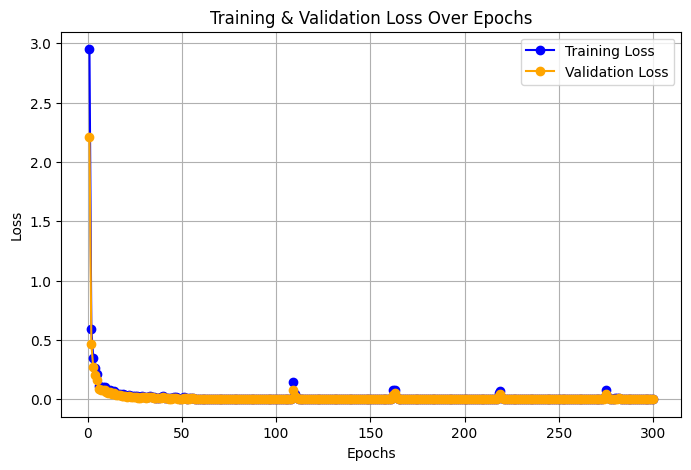

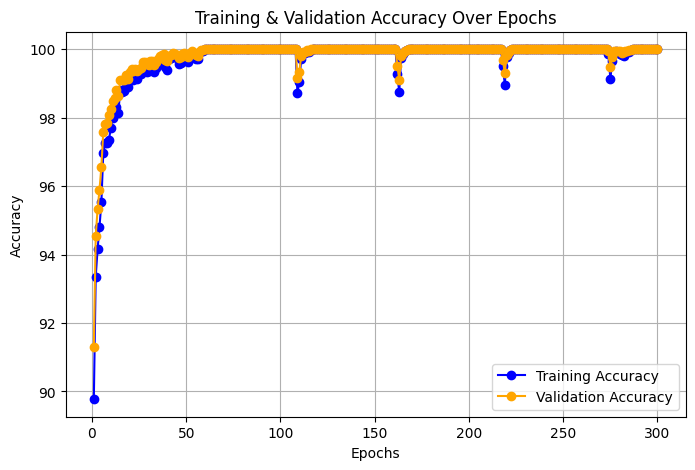

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch.cuda.memory as memory

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Dataset
file_path = "/content/drive/MyDrive/Salinas_Reduced.csv"
df = pd.read_csv(file_path)

# Extract Features and Labels
X = df.iloc[:, :-1].values  # First 204 columns as features
y = df.iloc[:, -1].values   # Last column as labels

# Standardize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to Tensors
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.long, device=device)

# Augmentation Functions
def add_gaussian_noise(X, mean=0, std=0.01):
    noise = np.random.normal(mean, std, X.shape)
    return np.clip(X + noise, -1, 1)

def mixup(X1, X2, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    return lam * X1 + (1 - lam) * X2

def augment_data(X, prob=0.5):
    if np.random.rand() < prob:
        X = add_gaussian_noise(X)
    return X

# Few-Shot Data Creation
def create_few_shot_batches(X, y, n_way=5, k_shot=5, query_per_class=10, episodes=500):
    unique_classes = np.unique(y)
    dataset = []

    for _ in range(episodes):
        selected_classes = np.random.choice(unique_classes, n_way, replace=False)
        support_set, query_set = [], []
        support_labels, query_labels = [], []

        for i, cls in enumerate(selected_classes):
            indices = np.where(y == cls)[0]
            selected_indices = np.random.choice(indices, k_shot + query_per_class, replace=False)

            support_set.append(augment_data(X[selected_indices[:k_shot]]))
            query_set.append(X[selected_indices[k_shot:]])
            support_labels.extend([i] * k_shot)
            query_labels.extend([i] * query_per_class)

        dataset.append((np.vstack(support_set), np.array(support_labels),
                        np.vstack(query_set), np.array(query_labels)))

    return dataset

n_way, k_shot, query_per_class = 5, 5, 10
episodes = 500
few_shot_data = create_few_shot_batches(X, y, n_way, k_shot, query_per_class, episodes)

# Improved Feature Extractor
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc = nn.Linear(256 * 204, 256)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Prototypical Network with Euclidean Distance
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = SpectralFeatureExtractor()

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)

        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# Initialize Model
model = PrototypicalNetwork().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
criterion = nn.CrossEntropyLoss()

# Training with Time Tracking & Memory Usage
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

start_time = time.time()
peak_memory = 0

def train_few_shot_model(model, data, optimizer, criterion, scheduler, epochs=300):
    global peak_memory
    model.train()

    for epoch in range(epochs):
        total_loss, total_correct, total_samples = 0, 0, 0
        val_loss, val_correct, val_samples = 0, 0, 0

        for support_x, support_y, query_x, query_y in data:
            support_x = torch.tensor(support_x, dtype=torch.float32, device=device)
            query_x = torch.tensor(query_x, dtype=torch.float32, device=device)
            query_y = torch.tensor(query_y, dtype=torch.long, device=device)

            optimizer.zero_grad()
            outputs = model(support_x, query_x)
            loss = criterion(outputs, query_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            total_correct += (outputs.argmax(dim=1) == query_y).sum().item()
            total_samples += query_y.size(0)

            # Validation Loss Calculation
            with torch.no_grad():
                val_outputs = model(support_x, query_x)
                val_loss += criterion(val_outputs, query_y).item()
                val_correct += (val_outputs.argmax(dim=1) == query_y).sum().item()
                val_samples += query_y.size(0)

            # Update Peak Memory
            peak_memory = max(peak_memory, memory.max_memory_allocated(device))

        train_losses.append(total_loss / len(data))
        val_losses.append(val_loss / len(data))
        train_accuracies.append(total_correct / total_samples * 100)
        val_accuracies.append(val_correct / val_samples * 100)

        print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_accuracies[-1]:.2f}%, "
              f"Val Acc: {val_accuracies[-1]:.2f}%, Peak Mem: {peak_memory / 1e6:.2f} MB")

train_few_shot_model(model, few_shot_data, optimizer, criterion, scheduler)

# End Training Timer
end_time = time.time()
print(f"Total Training Time: {end_time - start_time:.2f} seconds")
print(f"Peak Memory Usage: {peak_memory / 1e6:.2f} MB")

# Plot Loss and Accuracy
epochs_range = range(1, len(train_losses) + 1)

# Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_losses, label="Training Loss", marker='o', color='blue')
plt.plot(epochs_range, val_losses, label="Validation Loss", marker='o', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)


# Accuracy Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_accuracies, label="Training Accuracy", marker='o', color='blue')
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy", marker='o', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)

plt.show()

# **IP**

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Dataset
file_path = "/content/drive/MyDrive/IndianPines.csv"
df = pd.read_csv(file_path)

# Extract Features and Labels
X = df.iloc[:, :-1].values  # Features
y = df.iloc[:, -1].values   # Labels

# Standardize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to Tensors
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.long, device=device)

# Augmentation Functions
def add_gaussian_noise(X, mean=0, std=0.01):
    noise = np.random.normal(mean, std, X.shape)
    return np.clip(X + noise, -1, 1)

def mixup(X1, X2, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    return np.clip(lam * X1 + (1 - lam) * X2, -1, 1)

def augment_data(X, prob=0.7):
    if np.random.rand() < prob:
        X = add_gaussian_noise(X)
    if np.random.rand() < prob:
        indices = np.random.permutation(len(X))
        X = mixup(X, X[indices])
    return X

# Few-Shot Data Creation
def create_few_shot_batches(X, y, n_way=5, k_shot=5, query_per_class=10, episodes=500):
    unique_classes = np.unique(y)
    dataset = []
    for episode in range(episodes):
        selected_classes = np.random.choice(unique_classes, n_way, replace=False)
        support_set, query_set = [], []
        support_labels, query_labels = [], []
        for i, cls in enumerate(selected_classes):
            indices = np.where(y == cls)[0]
            if len(indices) < (k_shot + query_per_class):
                continue
            selected_indices = np.random.choice(indices, k_shot + query_per_class, replace=False)
            support_set.append(augment_data(X[selected_indices[:k_shot]]))
            query_set.append(X[selected_indices[k_shot:]])
            support_labels.extend([i] * k_shot)
            query_labels.extend([i] * query_per_class)
        dataset.append((np.vstack(support_set), np.array(support_labels),
                        np.vstack(query_set), np.array(query_labels)))
    return dataset

# Few-Shot Dataset Parameters
n_way, k_shot, query_per_class = 5, 5, 10
episodes = 500
few_shot_data = create_few_shot_batches(X, y, n_way, k_shot, query_per_class, episodes)

# Feature Extractor
class SpectralFeatureExtractor(nn.Module):
    def __init__(self, input_dim):
        super(SpectralFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, 7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128 * input_dim, 256)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self, input_dim):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = SpectralFeatureExtractor(input_dim)

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# Initialize Model
model = PrototypicalNetwork(X.shape[1]).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
criterion = nn.CrossEntropyLoss()

# Training Function
def train_few_shot_model(model, data, optimizer, criterion, scheduler, epochs=100):
    model.train()
    for epoch in range(epochs):
        total_loss, total_correct, total_samples = 0, 0, 0
        for support_x, support_y, query_x, query_y in data:
            support_x = torch.tensor(support_x, dtype=torch.float32, device=device)
            query_x = torch.tensor(query_x, dtype=torch.float32, device=device)
            query_y = torch.tensor(query_y, dtype=torch.long, device=device)
            optimizer.zero_grad()
            outputs = model(support_x, query_x)
            loss = criterion(outputs, query_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            total_correct += (outputs.argmax(dim=1) == query_y).sum().item()
            total_samples += query_y.size(0)
        epoch_loss = total_loss / len(data)
        epoch_acc = total_correct / total_samples * 100
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

# Train Model
train_few_shot_model(model, few_shot_data, optimizer, criterion, scheduler, epochs=300)

# Evaluate Model
def evaluate_few_shot_model(model, data):
    model.eval()
    total_correct, total_samples = 0, 0
    with torch.no_grad():
        for support_x, support_y, query_x, query_y in data:
            support_x = torch.tensor(support_x, dtype=torch.float32, device=device)
            query_x = torch.tensor(query_x, dtype=torch.float32, device=device)
            query_y = torch.tensor(query_y, dtype=torch.long, device=device)
            outputs = model(support_x, query_x)
            total_correct += (outputs.argmax(dim=1) == query_y).sum().item()
            total_samples += query_y.size(0)
    final_acc = total_correct / total_samples * 100
    print(f"Final Evaluation Accuracy: {final_acc:.2f}%")
    return final_acc

# Run Evaluation
evaluate_few_shot_model(model, few_shot_data)

Using device: cuda
Epoch 1/300, Loss: 1.2504, Accuracy: 77.85%
Epoch 2/300, Loss: 0.5836, Accuracy: 85.61%
Epoch 3/300, Loss: 0.4416, Accuracy: 87.92%
Epoch 4/300, Loss: 0.3064, Accuracy: 90.57%
Epoch 5/300, Loss: 0.2717, Accuracy: 91.65%
Epoch 6/300, Loss: 0.2094, Accuracy: 93.19%
Epoch 7/300, Loss: 0.1742, Accuracy: 94.10%
Epoch 8/300, Loss: 0.1493, Accuracy: 95.03%
Epoch 9/300, Loss: 0.1426, Accuracy: 95.23%
Epoch 10/300, Loss: 0.1196, Accuracy: 95.98%
Epoch 11/300, Loss: 0.1019, Accuracy: 96.59%
Epoch 12/300, Loss: 0.0896, Accuracy: 97.12%
Epoch 13/300, Loss: 0.0800, Accuracy: 97.27%
Epoch 14/300, Loss: 0.0623, Accuracy: 97.90%
Epoch 15/300, Loss: 0.0609, Accuracy: 97.96%
Epoch 16/300, Loss: 0.0540, Accuracy: 98.20%
Epoch 17/300, Loss: 0.0594, Accuracy: 98.13%
Epoch 18/300, Loss: 0.0503, Accuracy: 98.30%
Epoch 19/300, Loss: 0.0478, Accuracy: 98.43%
Epoch 20/300, Loss: 0.0366, Accuracy: 98.80%
Epoch 21/300, Loss: 0.0366, Accuracy: 98.74%
Epoch 22/300, Loss: 0.0338, Accuracy: 98.96%


99.252

In [ ]:
import os
import torch

# Define model directory and path
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_save_path = os.path.join(model_dir, "Augmented_PrototypicalNetwork_IP.pth")

# Create directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Save the model
torch.save(model.state_dict(), model_save_path)

print(f"Model saved at: {model_save_path}")

Model saved at: /content/drive/MyDrive/Model_Checkpoints/Augmented_PrototypicalNetwork_IP.pth


Using device: cuda
Epoch 1/300 | Train Loss: 1.0739, Train Acc: 79.43% | Val Loss: 0.4766, Val Acc: 85.47%
Epoch 2/300 | Train Loss: 0.3419, Train Acc: 88.30% | Val Loss: 0.3428, Val Acc: 88.56%
Epoch 3/300 | Train Loss: 0.2243, Train Acc: 91.79% | Val Loss: 0.2138, Val Acc: 91.87%
Epoch 4/300 | Train Loss: 0.1635, Train Acc: 94.18% | Val Loss: 0.2754, Val Acc: 91.08%
Epoch 5/300 | Train Loss: 0.1358, Train Acc: 95.26% | Val Loss: 0.1932, Val Acc: 93.06%
Epoch 6/300 | Train Loss: 0.1091, Train Acc: 96.14% | Val Loss: 0.2697, Val Acc: 92.22%
Epoch 7/300 | Train Loss: 0.0894, Train Acc: 97.02% | Val Loss: 0.2013, Val Acc: 93.37%
Epoch 8/300 | Train Loss: 0.0730, Train Acc: 97.52% | Val Loss: 0.2756, Val Acc: 91.99%
Epoch 9/300 | Train Loss: 0.0605, Train Acc: 97.98% | Val Loss: 0.2151, Val Acc: 93.68%
Epoch 10/300 | Train Loss: 0.0502, Train Acc: 98.21% | Val Loss: 0.2234, Val Acc: 93.58%
Epoch 11/300 | Train Loss: 0.0481, Train Acc: 98.44% | Val Loss: 0.2233, Val Acc: 93.48%
Epoch 12/30

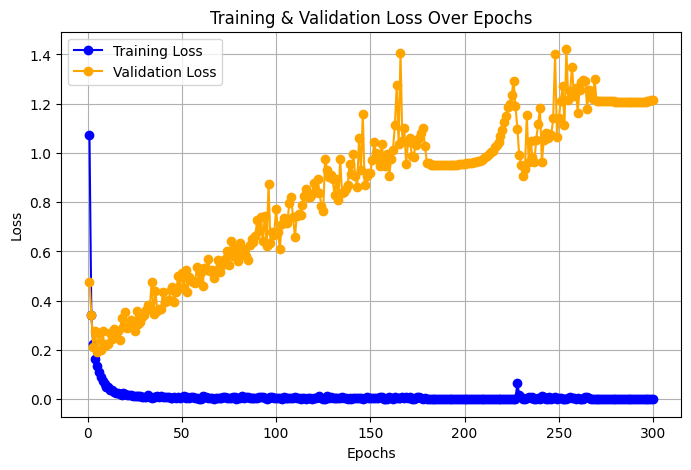

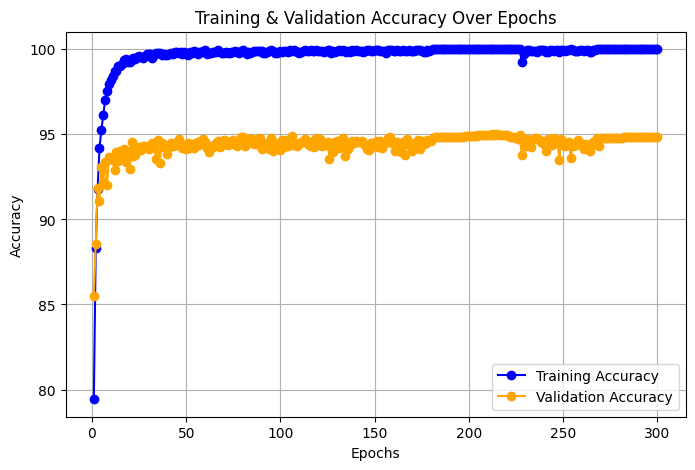

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Dataset
file_path = "/content/drive/MyDrive/IndianPines.csv"
df = pd.read_csv(file_path)

# Extract Features and Labels
X = df.iloc[:, :-1].values  # Features
y = df.iloc[:, -1].values   # Labels

# Standardize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to Tensors
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.long, device=device)

# Augmentation Functions
def add_gaussian_noise(X, mean=0, std=0.01):
    noise = np.random.normal(mean, std, X.shape)
    return np.clip(X + noise, -1, 1)

def mixup(X1, X2, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    return np.clip(lam * X1 + (1 - lam) * X2, -1, 1)

def augment_data(X, prob=0.7):
    if np.random.rand() < prob:
        X = add_gaussian_noise(X)
    if np.random.rand() < prob:
        indices = np.random.permutation(len(X))
        X = mixup(X, X[indices])
    return X

# Few-Shot Data Creation
def create_few_shot_batches(X, y, n_way=5, k_shot=5, query_per_class=10, episodes=500):
    unique_classes = np.unique(y)
    dataset = []
    for episode in range(episodes):
        selected_classes = np.random.choice(unique_classes, n_way, replace=False)
        support_set, query_set = [], []
        support_labels, query_labels = [], []
        for i, cls in enumerate(selected_classes):
            indices = np.where(y == cls)[0]
            if len(indices) < (k_shot + query_per_class):
                continue
            selected_indices = np.random.choice(indices, k_shot + query_per_class, replace=False)
            support_set.append(augment_data(X[selected_indices[:k_shot]]))
            query_set.append(X[selected_indices[k_shot:]])
            support_labels.extend([i] * k_shot)
            query_labels.extend([i] * query_per_class)
        dataset.append((np.vstack(support_set), np.array(support_labels),
                        np.vstack(query_set), np.array(query_labels)))
    return dataset

# Few-Shot Dataset Parameters
n_way, k_shot, query_per_class = 5, 5, 10
episodes = 500
few_shot_train = create_few_shot_batches(X, y, n_way, k_shot, query_per_class, episodes)
few_shot_val = create_few_shot_batches(X, y, n_way, k_shot, query_per_class, episodes)

# Feature Extractor
class SpectralFeatureExtractor(nn.Module):
    def __init__(self, input_dim):
        super(SpectralFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, 7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128 * input_dim, 256)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self, input_dim):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = SpectralFeatureExtractor(input_dim)

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# Initialize Model
model = PrototypicalNetwork(X.shape[1]).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
criterion = nn.CrossEntropyLoss()

# Training Function
def train_few_shot_model(model, train_data, val_data, optimizer, criterion, scheduler, epochs=100):
    model.train()
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    start_time = time.time()
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device)

    for epoch in range(epochs):
        total_loss, total_correct, total_samples = 0, 0, 0
        for support_x, support_y, query_x, query_y in train_data:
            support_x = torch.tensor(support_x, dtype=torch.float32, device=device)
            query_x = torch.tensor(query_x, dtype=torch.float32, device=device)
            query_y = torch.tensor(query_y, dtype=torch.long, device=device)

            optimizer.zero_grad()
            outputs = model(support_x, query_x)
            loss = criterion(outputs, query_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            total_correct += (outputs.argmax(dim=1) == query_y).sum().item()
            total_samples += query_y.size(0)

        epoch_loss = total_loss / len(train_data)
        epoch_acc = total_correct / total_samples * 100
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation Phase
        model.eval()
        val_loss, val_correct, val_samples = 0, 0, 0
        with torch.no_grad():
            for support_x, support_y, query_x, query_y in val_data:
                support_x = torch.tensor(support_x, dtype=torch.float32, device=device)
                query_x = torch.tensor(query_x, dtype=torch.float32, device=device)
                query_y = torch.tensor(query_y, dtype=torch.long, device=device)

                outputs = model(support_x, query_x)
                loss = criterion(outputs, query_y)

                val_loss += loss.item()
                val_correct += (outputs.argmax(dim=1) == query_y).sum().item()
                val_samples += query_y.size(0)

        val_losses.append(val_loss / len(val_data))
        val_accuracies.append(val_correct / val_samples * 100)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% | "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

    end_time = time.time()
    print(f"Total Training Time: {end_time - start_time:.2f} seconds")
    if torch.cuda.is_available():
        print(f"Peak Memory Usage: {torch.cuda.max_memory_allocated(device) / 1024**2:.2f} MB")

    return train_losses, train_accuracies, val_losses, val_accuracies

# Train Model
train_losses, train_accuracies, val_losses, val_accuracies = train_few_shot_model(
    model, few_shot_train, few_shot_val, optimizer, criterion, scheduler, epochs=300
)

# Plot Loss and Accuracy
epochs_range = range(1, len(train_losses) + 1)

# Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_losses, label="Training Loss", marker='o', color='blue')
plt.plot(epochs_range, val_losses, label="Validation Loss", marker='o', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)


# Accuracy Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_accuracies, label="Training Accuracy", marker='o', color='blue')
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy", marker='o', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)

plt.show()